## Config BO

In [1]:
from langchain.prompts.prompt import PromptTemplate

initial_train = 1
initial_transfer_train=0
ask_K = 1
N=20
M=2
lambda_multi = 0.1
# model="gpt-3.5-turbo-instruct"
model="gpt-turbo"

## Initialize Tranfer Learning Dataset

In [2]:
import pandas as pd
import numpy as np

random_seed = 10
np.random.seed(random_seed)

t_data_path="top_10_similar_subset.csv"

t_data_path = "/Users/shane/repos/BO-LIFT/" + t_data_path
transfer_data = pd.read_csv(t_data_path)

t_N = transfer_data.shape[0]
t_indexes = np.random.choice(transfer_data.shape[0], int(t_N), replace=False)
t_x_name = "prompt"
t_y_name = "completion"
len(t_indexes)

2910

### Build Focused Pool For Transfer Learning

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from openai import OpenAI
client = OpenAI()

model = "text-embedding-3-large"

def get_embeddings(texts, model=model, batch_size=100):
    all_embeddings = []
    cleaned_texts = [text.replace("\n", " ") if isinstance(text, str) else "" for text in texts]
    for i in range(0, len(cleaned_texts), batch_size):
        batch = cleaned_texts[i: i + batch_size]
        embeddings_data = client.embeddings.create(input=batch, model=model).data
        all_embeddings.extend([embedding.embedding for embedding in embeddings_data])
    return np.array(all_embeddings)

small_data_path = "/Users/shane/repos/BO-LIFT/paper/dataset/data/bias_free_ocmdataset_p_comp.csv" 
large_data_path = "/Users/shane/repos/BO-LIFT/paper/dataset/data/C2_yield_meth_oxy_short_corrected.csv"

small_data = pd.read_csv(small_data_path)
large_data = pd.read_csv(large_data_path)

prompt_col = "prompt"
completion_col = "completion"

small_prompts = small_data[prompt_col].fillna("").tolist()
large_prompts = large_data[prompt_col].fillna("").tolist()

small_embeddings = get_embeddings(small_prompts)
large_embeddings = get_embeddings(large_prompts)

similarities = cosine_similarity(small_embeddings, large_embeddings)

selected_indices = set()
new_data_list = []

for i, small_prompt in tqdm(enumerate(small_prompts), total=len(small_prompts)):

    sorted_indices = np.argsort(similarities[i])[::-1]

    count = 0
    for index in sorted_indices:
        if index not in selected_indices:
            large_prompt = large_data.iloc[index][prompt_col]
            completion_text = large_data.iloc[index][completion_col]
            new_data_list.append({"prompt": large_prompt, "completion": completion_text})
            selected_indices.add(index)
            count += 1
        if count == 10:
            break

new_data = pd.DataFrame(new_data_list)
t_data_path = "top_10_similar_subset.csv"
new_data.to_csv(t_data_path, index=False)


## in-house

In [35]:
dataset="in-house"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="CO STY",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7
)

path = f"./out/bias_free_ocmdataset_p_comp.pkl"
pool_path = "./dataset/data/42000_in-house_pool.pkl"


## OCM

In [57]:
dataset="ocm"
kwargs = dict(
    # prefix="You are a bot who knows chemistry and catalysts. " \
    #         "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
    #         "The following question should be answered with a number and finished with ###\n",
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="C2 yield",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7
)

inv_system_message_path = "./prompts/inv_prompt_1.txt"
system_message_path = "./prompts/prompt_1.txt"

# path = f"./out/{dataset}_{model}_300_{initial_train}_{ask_K}_lambda_mult{lambda_multi}_corrected_tableprompt_transfer_data_{initial_transfer_train}.pkl"

path = f"./out/{dataset}_{model}_{initial_train}_{ask_K}_lambda_mult{lambda_multi}_corrected_tableprompt_wlog_probs.pkl"
# pool_path = "./dataset/data/bias_free_ocmdataset_p_comp.pkl"

# path = f"./out/inv_system_message_test_{lambda_multi}.pkl"
pool_path = "./dataset/data/C2_yield_meth_oxy_short_corrected_allacqs1.pkl"

# Alloy

In [3]:
dataset="alloy"
kwargs = dict(
    # prefix="You are a bot who knows chemistry and catalysts. " \
    #         "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
    #         "The following question should be answered with a number and finished with ###\n",
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"the corresponding experimental procedure: {x}",
    y_name="the log(charge transfer) [coulombs/cm²]", # inverse prompt : If {y_name} is {y}, then {x_name} is @@@\n{x}###"
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7
)

inv_system_message_path = "/Users/shane/repos/BO-LIFT/paper/prompts/gpt4_alloy_dataset_tale.txt"
system_message_path = "./prompts/prompt_1.txt"

# path = f"./out/{dataset}_{model}_300_{initial_train}_{ask_K}_lambda_mult{lambda_multi}_corrected_tableprompt_transfer_data_{initial_transfer_train}.pkl"

path = f"./out/{dataset}_{model}_{initial_train}_{ask_K}_lambda_mult{lambda_multi}_wlog_probs.pkl"
# pool_path = "./dataset/data/bias_free_ocmdataset_p_comp.pkl"

# path = f"./out/inv_system_message_test_{lambda_multi}.pkl"
pool_path = "./dataset/data/alloys_allacqs1.pkl"

## Solubility

In [12]:
dataset="sol"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"iupac name {x}",
    y_name="measured log solubility in mols per litre",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7,
)

path = f"./out/{dataset}_{model}_882_{initial_train}_{ask_K}_16nr.pkl"
pool_path = "./out/sol_pool.pkl"


In [7]:
import langchain

# Setup

In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from langchain.prompts.prompt import PromptTemplate
import copy, cloudpickle
import seaborn as sns

import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.join(current_dir,'..')
sys.path.insert(0,parent_dir)

import bolift

from dotenv import load_dotenv
load_dotenv()

GPR Packages not installed. Do `pip install bolift[gpr]` to install them


True

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)


## Utils

In [6]:
# import uncertainty_toolbox as uct

def combine(s, l):
  '''Number of combinations of l elements with max = s'''
  return (s**l - (s-1)**(l))

def prob(s, l, n):
  '''Probability of getting a sample with max([x0,x1,...,xl]) = s where xi={0,n}'''
  return combine(s,l) * ((1/n)**l)

def expected_value_p(l, n):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  E = [s * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

def expected_value_q(l, n, data):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  quants = [data.quantile(i/100) for i in range(100+1)]
  # E = [(quants[s-1]) * prob(s, l, n) for s in range(1,100+1)]
  E = [((quants[s-1]+quants[s])/2) * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

# @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment(
    asktell, pool, raw_data, indexes, x_name, y_name, N=1, initial_train=1, ask_K=1, aq="random", start_index=0, calibrate=False,
    lambda_multi=0.1, system_message="", inv_system_message="",transfer_train=1, transfer=False, trans_data=transfer_data, t_indexes=t_indexes
):
    if aq=='random_mean':
       return [ (i, expected_value_q(i, 100, raw_data[y_name])) for i in range(1,N+initial_train) ]
    
    point=[]
    py = 0 
    mod_std = 0
    counter = 1
    for i in indexes[:initial_train]:
        
        asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))
        if counter == 1:
     
           i_best = float(raw_data[y_name].iloc[i])
        else:
           i_best = sorted(point, key=lambda i_points: i_points[-1])[-1][-3]
           
        point.append((raw_data[x_name].iloc[i],counter,i_best,float(raw_data[y_name].iloc[i]),py,mod_std))
        print("check",raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]),i_best)
        counter+=1

    if transfer:
      for j in t_indexes[:transfer_train]:
          asktell.tell(trans_data[x_name].iloc[j], float(trans_data[y_name].iloc[j]))
        
    if calibrate:
        # y = [float(raw_data[y_name].iloc[i]) for i in indexes[:initial_train]]
        # pred = asktell.predict(y)
        # ymeans = np.array([yhi.mean() for yhi in pred])
        # ystds = np.array([yhi.std() for yhi in pred])
        # calibration_factor = uct.recalibration.optimize_recalibration_ratio (ymeans, ystds, np.array(y), criterion="miscal")
        calibration_factor = 5.0
        asktell.set_calibration_factor(calibration_factor)

    x = raw_data[x_name].tolist()

    pool.reset()
    xi = x[start_index]
    x.remove(xi)
    pool.choose(xi)
    yi = float(raw_data[raw_data[x_name] == xi][y_name].iloc[0])
    asktell.tell(xi, yi)
    point.append((xi,1+initial_train,i_best, yi,py,mod_std))

    best = sorted(point, key=lambda points: points[-1])[-1][-3]

    for i in range(1, N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py, mod_std = asktell.ask(pool,
                                k=ask_K,
                                aq_fxn=aq,
                                _lambda=1.0,
                                inv_filter=16,
                                aug_random_filter=0,
                                lambda_mult=lambda_multi,
                                system_message=system_message,
                                inv_system_message=inv_system_message,
                                )
        for j in range(ask_K):
          xc = px[j]
          x.remove(xc)
          pool.choose(xc)
          y = float(raw_data[raw_data[x_name] == xc][y_name].iloc[0])
          asktell.tell(xc, y)
          best = max(y, best)
          print("here",best)
        point.append((xc, 1+initial_train+i*ask_K, best, y,py[0],mod_std[0]))
        
    return point

In [10]:
def get_dataset(data: str, M=M):
    match data:
        case "in-house":
            data_path = "./dataset/data/71023_BO_ready_pool.csv"
            raw_data = pd.read_csv(data_path)

            raw_data['Catalyst'] = raw_data['Prompt'].str.extract(r'(\b[A-Z][a-z]?:[A-Z][a-z]?:[A-Z][a-z]?\b)')
            unique_cat = raw_data['Catalyst'].unique()
            c = {c: 0.2+m*(5/len(unique_cat)) for m, c in enumerate(unique_cat)}
            raw_data['dummy_Completion'] = raw_data['Catalyst'].apply(lambda x: np.random.normal(c[x], 0.05))

            x_name = "Prompt"
            y_name = "dummy_Completion"
        case "ocm":
            data_path = "./dataset/data/C2_yield_meth_oxy_short_corrected.csv"
            raw_data = pd.read_csv(data_path, sep=",")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "alloy":
            data_path = "/Users/shane/repos/BO-LIFT/paper/dataset/processed_with_log_delta_n.csv"
            raw_data = pd.read_csv(data_path, sep=",")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "biasfree_ocm":
            data_path = "./dataset/data/bias_free_ocmdataset_p_comp.csv"
            raw_data = pd.read_csv(data_path, sep=",")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "sol":
            data_path = "./dataset/data/esol_iupac.csv"
            raw_data = pd.read_csv(data_path)
            raw_data = raw_data.dropna()
            raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
            x_name = "IUPAC"
            y_name = "measured log(solubility:mol/L)"
        case _:
            raise ValueError("Unknown data")
        
    n_data = raw_data.shape[0]
    indexes = np.random.choice(raw_data.shape[0], int(n_data), replace=False)

    print(f"Dataset size: \n\t{n_data}")
    starts = raw_data.sort_values(by=y_name, ascending=True).head(5).sample(M+initial_train)# np.random.randint(0, len(indexes), M)
    print(f"Start xs: \n\t{starts[x_name].to_list()}")
    print(f"Start ys: \n\t{starts[y_name].to_list()}")
    starts = starts.index
    print(f"Start indexes: \n\t{starts}\n")

    return raw_data, starts, indexes, x_name, y_name


In [11]:
def get_asktell(model: str, kwargs: dict = {}, pool: bolift.Pool = None, knn: int = 1):
    match model:
        case "instruct":
            kwargs['model']="gpt-3.5-turbo-instruct"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-turbo":
            kwargs['model']="gpt-3.5-turbo-0125"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4":
            kwargs['model']="gpt-4-0125-preview"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4o":
            kwargs['model']="gpt-4o"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "davinci":
            kwargs['model']="davinci-002"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "curie":
            kwargs['model']="text-curie-001"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpr":
            kwargs['selector_k'] = 0
            kwargs['pool'] = pool if pool else None
            kwargs['n_components'] = 32
            return bolift.AskTellGPR(**kwargs)
        # knn and krr don't output uncertainties
        # case "knn":
        #     del kwargs['selector_k']
        #     kwargs['knn'] = knn
        #     return bolift.AskTellNearestNeighbor(**kwargs)
        # case "krr":
        #     kwargs['alpha'] = 0.5
        #     return bolift.AskTellRidgeKernelRegression(**kwargs)
        case _:
            raise ValueError("Unknown model")

In [12]:
def read_bkp(path, pool_path, indexes, kwargs):
    if os.path.exists(pool_path):
        with open(pool_path, "rb") as f:
            pool = cloudpickle.load(f)
        pool.reset()
    else:
        x = [raw_data[x_name].iloc[i] for i in indexes]
        pool = bolift.Pool(list(x), formatter=kwargs['x_formatter'])

        # cloudpickle.dump(pool, open(pool_path, "wb"))

    if os.path.exists(path):
        bayesOpts = cloudpickle.load(open(path, "rb"))
    else:
        bayesOpts = {}
    return bayesOpts, pool

# BayesOpt experiments

## Run BO

In [13]:

np.random.seed(28)

import warnings
warnings.filterwarnings('ignore', message='Changing the sparsity structure of a csr_matrix is expensive.*')
warnings.filterwarnings('ignore', message='Input data is not contained to the unit cube.*')
warnings.filterwarnings('ignore', message='Input data is not standardized.*')
warnings.filterwarnings('ignore', message="Keyword arguments .* will be ignored because they are not allowed parameters for function .*", category=UserWarning)

raw_data, starts, indexes, x_name, y_name = get_dataset(dataset, M=M)
bayesOpts, pool = read_bkp(path, pool_path, indexes, kwargs)

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()

asktell = get_asktell(model, kwargs=kwargs)#, pool=bolift.Pool(list(pool.sample(5000))), knn=5)

Dataset size: 
	8783
Start xs: 
	['An interface between HoCuO2 (Fermi level: 5.67 meV) and ZrSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.77 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between NbS2 (Fermi level: 5.67 meV) and Pb(ClO3)2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.95 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between La2(SiO3)3 (Fermi level: 5.67 meV) and TiSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.1 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.']
Start ys: 
	[-6.5713, -5.8604, -6.3596]
Start indexes: 
	Index([2176, 8086, 6714], dtype='int64')



In [15]:
import warnings
warnings.filterwarnings('ignore', message='Changing the sparsity structure of a csr_matrix is expensive.*')
warnings.filterwarnings('ignore', message='Input data is not contained to the unit cube.*')
warnings.filterwarnings('ignore', message='Input data is not standardized.*')
warnings.filterwarnings('ignore', message="Keyword arguments .* will be ignored because they are not allowed parameters for function .*", category=UserWarning)

for aq in ['expected_improvement',"greedy","random","random_mean"]: #,'log_expected_improvement','expected_improvement',"probability_of_improvement","greedy",
    print(aq, "start:", end=" ")
    points = []
    for i in range(M):
        print(i, end=",  ")        
        point = run_experiment(
            copy.deepcopy(asktell),
            pool, # copy.deepcopy(pool)
            raw_data,
            indexes=indexes,
            x_name=x_name,
            y_name=y_name,
            N=N,
            aq=aq,
            start_index=starts[i+initial_train],
            calibrate=True,
            initial_train=initial_train,
            ask_K=ask_K,
            lambda_multi=lambda_multi,
            system_message=system_message,
            inv_system_message=inv_system_message,
            transfer_train=initial_transfer_train,
            transfer=False,
            trans_data=transfer_data,
            t_indexes=t_indexes)
        
        points.append(point)
    points = np.array(points)
    bayesOpts[aq] = points
    print(aq, "done")
    # if isinstance(asktell, bolift.AskTellGPR):
    #     asktell.save_cache("GPR_ada_embed_cache.csv")
    cloudpickle.dump(bayesOpts, open(path, "wb"))
cloudpickle.dump(bayesOpts, open(path, "wb"))


expected_improvement start: 0,  check An interface between La4Re6O19 (Fermi level: 5.67 meV) and NbS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.72 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials. 0.5188 0.5188
Given the log(charge transfer) values and the template for generating experimental procedures, here are the complete responses for the remaining scenarios:

1. If the log(charge transfer) [coulombs/cm²] is 0.83, then the input is @@@
the corresponding experimental procedure: An interface between NbS2 (Fermi level: 5.67 meV) and NbS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.72 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###

These responses ensure that the generated experimental procedures are consistent with the given charge 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.6603
An interface between CuLaO3 (Fermi level: 5.67 meV) and Ce2S3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.73 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between Zr3Se2 (Fermi level: 5.67 meV) and La2CuO4 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.77 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between LuGaO3 (Fermi level: 5.67 meV) and NbS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.07 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between CeU5O12 (Fermi level: 5.67 meV) and PdS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor.

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.6603
If the log(charge transfer) [coulombs/cm²] is 3.13, then the input is @@@

the corresponding experimental procedure: An interface between Si6Cl8 (Fermi level: 5.67 meV) and Zn3O2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.46 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.### 

If you have any more queries or need further assistance, feel free to ask!
['An interface between H7ClO3 (Fermi level: 5.67 meV) and ZrS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between VS2 (Fermi level: 5.67 meV) and LiGa5O8 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.92 Å, calculated as the sum of the maximum van der W

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.6603
If the log(charge transfer) [coulombs/cm²] is 3.16, then the input is missing from the provided message. Could you please provide the necessary information to generate the corresponding experimental procedure?
['An interface between VS2 (Fermi level: 5.67 meV) and Li6CrO4 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.1 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between H3ClO5 (Fermi level: 5.67 meV) and PdS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.55 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Te2Mo (Fermi level: 5.67 meV) and InCuO3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.62 Å, calculated as the sum of the

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.6603
If the log(charge transfer) [coulombs/cm²] is 2.84, then the input is @@@  
the corresponding experimental procedure: An interface between Ba2C (Fermi level: 5.67 meV) and Yb2UO3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.73 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between VS2 (Fermi level: 5.67 meV) and YbI2O (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.57 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between BaTiO3 (Fermi level: 5.67 meV) and Zr9S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.25 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface b

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.3324
If the log(charge transfer) [coulombs/cm²] is 1.59, then the input is @@@

the corresponding experimental procedure: An interface between La2(SiO3)3 (Fermi level: 5.67 meV) and TiSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.1 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between Li6CrO4 (Fermi level: 5.67 meV) and TaSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.95 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between TiCrO3 (Fermi level: 5.67 meV) and TiS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.05 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An inter

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
If the log(charge transfer) [coulombs/cm²] is 1.97, then the input is missing from your message. Could you provide the specific log(charge transfer) value for me to generate the corresponding experimental procedure?
['An interface between VS2 (Fermi level: 5.67 meV) and LiClO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.87 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between KMn2O4 (Fermi level: 5.67 meV) and Ti3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.75 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between H3ClO5 (Fermi level: 5.67 meV) and Te2W (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 1.75 Å, calculated as the sum 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
If the log(charge transfer) [coulombs/cm²] is 2.12, then the input is missing. Could you please provide the necessary information for me to generate the corresponding experimental procedure?
['An interface between VS2 (Fermi level: 5.67 meV) and LiClO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.87 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between KMn2O4 (Fermi level: 5.67 meV) and Ti3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.75 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Li6CrO4 (Fermi level: 5.67 meV) and TaSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.95 Å, calculated as the sum of the maximum van der 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
An interface between Li2SiF6 (Fermi level: 5.67 meV) and FePb (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.74 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between Li5Fe3O8 (Fermi level: 5.67 meV) and ZrS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.25 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between NbS2 (Fermi level: 5.67 meV) and Pb(ClO3)2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.95 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Fe3(O2F)2 (Fermi level: 5.67 meV) and Te2Pd (Fermi level: 4.23 meV) is modeled as a parallel plate capac

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
### Response:

If the log(charge transfer) [coulombs/cm²] is 1.84, then the input is @@@

the corresponding experimental procedure: An interface between Hf5S2 (Fermi level: 5.67 meV) and MoO5 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.95 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between Li4MoO5 (Fermi level: 5.67 meV) and HfS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.9 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between H5ClO6 (Fermi level: 5.67 meV) and HfSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.65 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
If the log(charge transfer) [coulombs/cm²] is 2.04, then the input is missing. Please provide the necessary information for me to generate the corresponding experimental procedure for you.
['An interface between KMn2O4 (Fermi level: 5.67 meV) and Te2Pt (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 2.75 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Co(IO3)2 (Fermi level: 5.67 meV) and Zr3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.25 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Li3Mn4O8 (Fermi level: 5.67 meV) and MoS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.15 Å, calculated as the sum of the maximum van de

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
Based on the log(charge transfer) values provided, here are the corresponding experimental procedures for the missing log(charge transfer) value:

If the log(charge transfer) [coulombs/cm²] is 1.79, then the input is @@@
the corresponding experimental procedure: An interface between PdS2 (Fermi level: 5.67 meV) and Li2Se (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.70 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between Li2(NiO2)3 (Fermi level: 5.67 meV) and Pd7Se2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.87 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between PbSe2O5 (Fermi level: 5.67 meV) and MoS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation betwe

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
If the log(charge transfer) [coulombs/cm²] is 1.85, then the input is @@@

the corresponding experimental procedure: An interface between K2Ca2N2 (Fermi level: 5.67 meV) and F3O2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 2.37 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between K4CO4 (Fermi level: 5.67 meV) and Zr3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 5 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Mn6O7F5 (Fermi level: 5.67 meV) and Te2Mo (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.15 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface b

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
Great job on providing the experimental procedures based on the specified charge transfer values! Here's the completion for the last scenario:

If the log(charge transfer) [coulombs/cm²] is 2.05, then the input is @@@
the corresponding experimental procedure: An interface between BeI2 (Fermi level: 5.67 meV) and CsO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.91 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.### 

Feel free to let me know if you need further assistance or have any other scenarios to work on!
['An interface between VS2 (Fermi level: 5.67 meV) and CaB4O7 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.36 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between ScClO (Fermi level: 5.67 meV) and Te2Pt 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
The input for the log(charge transfer) of 1.95 is missing. Could you provide the value for the log(charge transfer) of 1.95 so that I can generate the corresponding experimental procedure for you?
['An interface between LiPrO2 (Fermi level: 5.67 meV) and Zr9S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.07 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between VS2 (Fermi level: 5.67 meV) and Ag2SO4 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.85 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Mn2PO5 (Fermi level: 5.67 meV) and TaSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.95 Å, calculated as the sum of the maximum van

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
Given the log(charge transfer) values provided, here are the corresponding experimental procedures:

1. If the log(charge transfer) is 1.92:
   - **Input:** @@@
   - **Experimental Procedure:** An interface between Ca(H8O5)2 (Fermi level: 5.67 meV) and PtS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.11 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###

For the remaining scenarios, could you please provide the log(charge transfer) values so I can determine the corresponding experimental procedures for each case?
['An interface between Te2Mo (Fermi level: 5.67 meV) and Li2CO3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.92 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between H3ClO5 (Fermi level: 5.67 meV) and

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
### Response:

If the log(charge transfer) [coulombs/cm²] is 1.98, then the input is missing. Please provide the necessary information for me to generate the corresponding experimental procedure.
['An interface between VS2 (Fermi level: 5.67 meV) and Li6CrO4 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.1 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between H3ClO5 (Fermi level: 5.67 meV) and PdS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.55 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between KMnO2 (Fermi level: 5.67 meV) and TiS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.75 Å, calculated as the sum of the maximum van der

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
If the log(charge transfer) [coulombs/cm²] is 1.90, then the input is @@@

The corresponding experimental procedure: An interface between Te3Zr (Fermi level: 5.67 meV) and KMo (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.42 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###

This response follows the specified format, providing a detailed experimental procedure based on the given input parameters and valid element combinations.
['An interface between Te2Mo (Fermi level: 5.67 meV) and KCrO3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.85 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Li4ZrO4 (Fermi level: 5.67 meV) and Zr3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 1.6174
The input corresponding to a log(charge transfer) of 1.92 is:

### @@@
the corresponding experimental procedure: An interface between K2(SnI4) (Fermi level: 5.67 meV) and KCd(SO4)2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.64 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between K6CdO4 (Fermi level: 5.67 meV) and Ta3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.55 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between KPO4 (Fermi level: 5.67 meV) and VS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.8 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface b

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
To determine the corresponding experimental procedure for a log(charge transfer) of 11.13, we need to calculate the interface between two materials based on the given parameters and constraints. Let's proceed with the calculation:

Given:
- log(charge transfer) = 11.13

We will now calculate the experimental procedure based on the provided template and constraints. Let's determine the elements and their Fermi levels that will form a valid compound for this high log(charge transfer) value. Let's calculate the separation distance as well. 

### Calculations:
- Selecting elements and Fermi levels for the interface based on the log(charge transfer) value.

### Experimental Procedure:
- An interface between {formula} (Fermi level: {efermi} meV) and {formula2} (Fermi level: {efermi-2} meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is {distance_d} Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
### Input for Log(Charge Transfer) = 10.56:
the corresponding experimental procedure: An interface between PuTe2 (Fermi level: 5.67 meV) and K2SbF7 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 2.81 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###

For the log(charge transfer) value of 10.56, the input generated above provides the corresponding experimental procedure based on the given elements and Fermi levels.
['An interface between Te2Mo (Fermi level: 5.67 meV) and Pu2SO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.9 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between KAl11O17 (Fermi level: 5.67 meV) and TaTe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
If the log(charge transfer) [coulombs/cm²] is 10.40, then the input is @@@

the corresponding experimental procedure: An interface between O2 (Fermi level: 5.67 meV) and U2S3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.23 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between U(OF)2 (Fermi level: 5.67 meV) and Ti3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.52 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between LiCuO2 (Fermi level: 5.67 meV) and MoS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.92 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface bet

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
If the log(charge transfer) [coulombs/cm²] is 11.39, then the input is @@@
the corresponding experimental procedure: An interface between Pu2O7 (Fermi level: 5.67 meV) and YbCl3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.82 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.### 

When dealing with a log(charge transfer) value of 11.39, the elements Pu, O, Yb, and Cl were selected to form the compounds Pu2O7 and YbCl3, ensuring that the resulting compounds are chemically valid.
['An interface between Zr3Se2 (Fermi level: 5.67 meV) and Pu2SO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.05 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between YbCrO3 (Fermi level: 5.67 meV) and NbS2 (Fermi level: 4.23 meV) is modele

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
To provide you with the corresponding experimental procedure for a log(charge transfer) of 10.59, I will need to calculate the separation distance between the two surfaces based on the given charge transfer value and the elements chosen for the materials. Let's proceed with the calculation.
['An interface between H7ClO3 (Fermi level: 5.67 meV) and Te2Mo (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.85 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Li3Mn4O8 (Fermi level: 5.67 meV) and TiS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.05 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Al10Ge2O19 (Fermi level: 5.67 meV) and Zr3Se2 (Fermi level: 4.23 meV) is modeled as a parallel plate

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
If the log(charge transfer) [coulombs/cm²] is 10.87, then the input is @@@

the corresponding experimental procedure: An interface between CBr2 (Fermi level: 5.67 meV) and Zr2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.5 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###

This response ensures that the elements selected form valid compounds and follows the required experimental procedure format.
['An interface between BeCr2O4 (Fermi level: 5.67 meV) and ZrS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.3 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between H7ClO3 (Fermi level: 5.67 meV) and ZrTe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4 Å,

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
If the log(charge transfer) [coulombs/cm²] is 10.37, then the input is missing from your message. Could you please provide the information for this specific case so I can generate the corresponding experimental procedure for you?
['An interface between Ho10Ti6O27 (Fermi level: 5.67 meV) and ZrS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.25 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between LiClO2 (Fermi level: 5.67 meV) and MoSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.92 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between VS2 (Fermi level: 5.67 meV) and LiMnO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.1 Å, calcu

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
If the log(charge transfer) [coulombs/cm²] is 12.19, then the input is @@@

the corresponding experimental procedure: An interface between Li3N (Fermi level: 5.67 meV) and PtS (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.12 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between Li7(NiO2)12 (Fermi level: 5.67 meV) and PtS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.77 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between LiNO3 (Fermi level: 5.67 meV) and Te2Mo (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.92 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interfac

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
### Input for Log(Charge Transfer) Values:

1. If the log(charge transfer) [coulombs/cm²] is **-0.78**, then the input is **VS2** for **formula** and **Cr4OF11** for **formula2**.
   
2. If the log(charge transfer) [coulombs/cm²] is **-1.20**, then the input is **VS2** for **formula** and **LiClO2** for **formula2**.
   
3. If the log(charge transfer) [coulombs/cm²] is **1.34**, then the input is **LiNO3** for **formula** and **Te2Mo** for **formula2**.
   
4. If the log(charge transfer) [coulombs/cm²] is **2.03**, then the input is **In(PO3)3** for **formula** and **Te2Pt** for **formula2**.
   
5. If the log(charge transfer) [coulombs/cm²] is **1.73**, then the input is **Te2Mo** for **formula** and **LuTiO3** for **formula2**.

6. If the log(charge transfer) [coulombs/cm²] is **11.62**, the charge transfer value is considerably high, and it might indicate an error or an outlier in the data. Please review the data and calculations to ensure accuracy.

### Corresponding Ex

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
Given the information provided, the corresponding experimental procedure for a log(charge transfer) of 10.30 would be:

### If the log(charge transfer) [coulombs/cm²] is 10.30, then the input is @@@
the corresponding experimental procedure: An interface between MgCl2 (Fermi level: 5.67 meV) and Ba3Sb (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.81 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between VS2 (Fermi level: 5.67 meV) and Mg(IO3)2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.78 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Ba3Co10O17 (Fermi level: 5.67 meV) and Pd7Se2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces i

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 9.2873
If the log(charge transfer) [coulombs/cm²] is 12.17, then the input is @@@

the corresponding experimental procedure: An interface between PdO4Te3 (Fermi level: 5.67 meV) and Cs4Pd (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 2.5 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.### 

Please let me know if you need any more assistance or further explanations!
['An interface between Co6O5F7 (Fermi level: 5.67 meV) and Te2Pd3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.63 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Cs2SO4 (Fermi level: 5.67 meV) and Pd7Se2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.7 Å, calculated as the sum of the maximum 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.0229
the corresponding experimental procedure: An interface between TeO2 (Fermi level: 5.67 meV) and SiS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.75 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between Te2W (Fermi level: 5.67 meV) and Be2Si2O5 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 2.1 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between SiP2O7 (Fermi level: 5.67 meV) and TaS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.9 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between GaTeO3 (Fermi level: 5.67 meV) and VS2 (Fermi level: 4.23 meV) is mode

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.0229
Given the log(charge transfer) values provided, here are the corresponding experimental procedures based on the template format:

1. If the log(charge transfer) [coulombs/cm²] is 2.39, then the input is:
   - The corresponding experimental procedure: An interface between CdS (Fermi level: 5.67 meV) and Ca3Bi2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.3 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.
['An interface between VS2 (Fermi level: 5.67 meV) and Cd2PbO4 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.57 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between CdCl2O (Fermi level: 5.67 meV) and MoS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.0229
### System Message:

You possess advanced expertise in electronic behavior at material interfaces, focusing on charge transfer and interactions between materials with differing Fermi levels. Your task is to generate detailed experimental protocols based on input parameters, which include element combinations, Fermi levels, and separation distances between materials.

**Objective:**  
Your response must strictly follow the procedure template format provided below and should include only one clear and consistent experimental procedure for each input query. Responses are expected to accurately map the charge transfer information to the template, ensuring that selected elements are valid based on the given sets of possible elements and that the resulting compounds are chemically valid.

**Element Selection Constraints:**  
- You can use the following elements for both **formula** (first material) and **formula2** (second material):  
  ['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.4765
Based on the log(charge transfer) values provided, the corresponding experimental procedures are as follows:

1. If the log(charge transfer) [coulombs/cm²] is 2.78, then the corresponding experimental procedure is:
   the corresponding experimental procedure: An interface between LaTiO3 (Fermi level: 5.67 meV) and As2Te3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.1 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between La2(SiO3)3 (Fermi level: 5.67 meV) and Ti3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.1 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between In(PO3)3 (Fermi level: 5.67 meV) and Te2Pt (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation betwee

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.4765
Great job on providing the experimental procedures based on the given charge transfer values! To complete the response for a log(charge transfer) of 3.16, the input you should provide is:

### If the log(charge transfer) [coulombs/cm²] is 3.16, then the input is @@@

### the corresponding experimental procedure: An interface between Pu2S3 (Fermi level: 5.67 meV) and Nd2Te3 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.45 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.### 

Remember to make sure that the elements you choose are from the provided list and that the compounds formed are chemically valid!
['An interface between Te2Mo (Fermi level: 5.67 meV) and Pu2SO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.9 Å, calculated as the sum of the maximum van der Waals radii of the constituent 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.4765
Great job on providing the experimental procedures based on the given charge transfer values! To determine the input for a log(charge transfer) of 2.96, you should follow the element selection constraints and generate a chemically valid compound for the interface. Once you have the compound names and Fermi levels, you can calculate the separation distance using the provided formula and complete the experimental procedure.

Looking forward to seeing your response for the log(charge transfer) of 2.96!
['An interface between VS2 (Fermi level: 5.67 meV) and Li6CrO4 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.1 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between In(PO3)3 (Fermi level: 5.67 meV) and TaSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.7 Å, calculated as the

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.4765
If the log(charge transfer) [coulombs/cm²] is 2.83, then the input is missing from your message. Could you please provide the necessary information so I can generate the corresponding experimental procedure for you?
['An interface between VS2 (Fermi level: 5.67 meV) and LiClO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.87 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between KMn2O4 (Fermi level: 5.67 meV) and Ti3S2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 4.75 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between H3ClO5 (Fermi level: 5.67 meV) and Te2W (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 1.75 Å, calculated as the sum 

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.4765
If the log(charge transfer) [coulombs/cm²] is 3.17, then the input is missing. Could you please provide the value for this case so I can generate the corresponding experimental procedure for you?
['An interface between VS2 (Fermi level: 5.67 meV) and LiClO2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.87 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Cr3HO8 (Fermi level: 5.67 meV) and Te2W (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 2.05 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between Mg(IO3)2 (Fermi level: 5.67 meV) and Pd7Se2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.63 Å, calculated as the sum of the maximum va

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.4765
If the log(charge transfer) [coulombs/cm²] is 2.91, then the input is @@@

the corresponding experimental procedure: An interface between AgClO2 (Fermi level: 5.67 meV) and YbSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 1.75 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.###
['An interface between AgClO2 (Fermi level: 5.67 meV) and PtSe2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.65 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface between VS2 (Fermi level: 5.67 meV) and YbI2O (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.57 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.', 'An interface b

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.4765
### Model Inputs and Corresponding Experimental Procedures:

1. If the log(charge transfer) [coulombs/cm²] is -1.95, then the input is **VS2** and **CdCl2O**:
   - The corresponding experimental procedure: An interface between **CdCl2O** (Fermi level: 5.67 meV) and **VS2** (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.8 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.

2. If the log(charge transfer) [coulombs/cm²] is 1.45, then the input is **VS2** and **TaCuO3**:
   - The corresponding experimental procedure: An interface between **VS2** (Fermi level: 5.67 meV) and **TaCuO3** (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.57 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials.

3. If the log(charge transfer) [coulombs/cm²] is 2.48, then

/Users/shane/repos/BO-LIFT/paper/../bolift/llm_model.py:314: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


here 2.4765
greedy done
random start: 0,  check An interface between La4Re6O19 (Fermi level: 5.67 meV) and NbS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.72 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials. 0.5188 0.5188
here 0.7031
here 0.7129
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 1.8703
here 6.966
here 8.2965
here 8.2965
1,  check An interface between La4Re6O19 (Fermi level: 5.67 meV) and NbS2 (Fermi level: 4.23 meV) is modeled as a parallel plate capacitor. The separation between the two surfaces is 3.72 Å, calculated as the sum of the maximum van der Waals radii of the constituent elements in both materials. 0.5188 0.5188
here 0.3577
here 0.3577
here 1.0986
here 1.0986
here 1.0986
here 1.0986
here 1.0986
here 1.0986
here 1.0986
here 1.23

### Quick plot

In [ ]:
# Quick test
# path = "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tablepromptgpt44.pkll"
title = "" #f"{path[6:-4]}" 
d = cloudpickle.load(open(path, "rb"))
# d = bayesOpts
data=raw_data[y_name]
lim=(data.min()-1, data.max()+1)

# name = "LogS"
name = "C$_2$ yield"
# name = "CO STY"

def plot_config():
    plt.title(title)
    plt.axhline(y=data.max(), color="C15", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.99), color="C14", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.95), color="C13", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.mean(), color="C12", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.05), color="C11", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.05), "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.min(), color="C10", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.min(), "Min", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.ylim(lim)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),
          fancybox=True, shadow=True, ncol=3)

#Debugging plots
# Plot best value on the entire run
plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
# plt.ylabel("Max C$_2$ yield")
plt.ylabel(f"Max {name}")

for i, acq in enumerate(d.keys()):
    if acq == "log_expected_improvement":
        continue
    if acq == "random_mean":
        plt.plot(d[acq][0,:,0].astype(int), d[acq][:, :, 1].astype(float).mean(axis=0), 
                 label=f"random", color="gray", linestyle="dashed")
    else:
        for j in range(M):
            try:
                plt.plot(d[acq][j,:,1].astype(int), d[acq][j, :, 2].astype(float), alpha=0.2, color=f"C{i}")
                plt.plot(d[acq][j,:,1].astype(int), d[acq][j, :, 4].astype(float), alpha=0.2, color=f"C{i}")
            except:
                continue
        plt.plot(d[acq][0,initial_train:,1].astype(int), d[acq][:, initial_train:, 2].astype(float).mean(axis=0), label=acq, color=f"C{i}")
        #plt.errorbar(d[acq][0,initial_train:,1].astype(int),d[acq][:, initial_train:, 4].astype(float).mean(axis=0), yerr=d[acq][:, initial_train:, 5].astype(float).mean(axis=0),fmt='o', color='green', ecolor='green', capsize=5, alpha=0.7, label=f"{acq}")
plot_config()
plt.show()

# # Plot current values on each iteration
# plt.figure(figsize=(8,5))
# plt.xlabel("Number of samples")
# plt.ylabel(f"{name}")
# for acq in d.keys():
#     if acq == "random_mean" or acq == "log_expected_improvement" or acq == "random":
#         continue
#     else:
#         for i in range(M-1):
#             plt.plot(d[acq][i,:,1], d[acq][i, :, 3].astype(float), label=f"{acq}:{i}", alpha=0.2)
#             plt.plot(d[acq][i,:,1], d[acq][i, :, 4].astype(float), label=f"{acq}:{i}", alpha=0.2)
#         plt.plot(d[acq][0,:,1], d[acq][:, :, 3].astype(float).mean(axis=0), label=f"{acq}")
#         plt.errorbar(d[acq][0,:,1],d[acq][:, :, 4].astype(float).mean(axis=0), yerr=d[acq][:, :, 5].astype(float).mean(axis=0),fmt='o', color='green', ecolor='green', capsize=5, alpha=0.7, label=f"{acq}")
# plot_config()
# plt.show()


### BayesOpt Plot

In [146]:
def plot_BO(ax, data_file, title, data, axis_name, lim=None, label=False, M=1):
    d = cloudpickle.load(open(data_file, "rb"))

    for i in range(M):
        if "expected_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['expected_improvement'][i, initial_train:, 1]],
            [float(y) for y in d['expected_improvement'][i, initial_train:, 2]],
            color="C1", alpha=0.2
          )
          # ax.plot(
          #   [int(s) for s in d['expected_improvement'][i, initial_train:, 1]],
          #   [float(y) for y in d['expected_improvement'][i, initial_train:, 4]],
          #   color="C9", alpha=0.2
          # )
        if "greedy" in d.keys():
           ax.plot(
            [int(s) for s in d['greedy'][i, initial_train:, 1]],
            [float(y) for y in d['greedy'][i, initial_train:, 2]], 
            color="C2", alpha=0.2
          )
        if "upper_confidence_bound" in d.keys():
          ax.plot(
            [int(s) for s in d['upper_confidence_bound'][i, initial_train:, 1]],
            [float(y) for y in d['upper_confidence_bound'][i, initial_train:, 2]], 
            color="C3", alpha=0.2
          )
        if "probability_of_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['probability_of_improvement'][i, initial_train:, 1]],
            [float(y) for y in d['probability_of_improvement'][i, initial_train:, 2]], 
            color="C4", alpha=0.2
          )
        if "random" in d.keys():
          ax.plot(
            [int(s) for s in d['random'][i, :, 1]],
            [float(y) for y in d['random'][i, :, 2]], 
            color="C8", alpha=0.2
          )
    if "expected_improvement" in d.keys():
      label = "EI" if label else None
      ax.plot(
            d['expected_improvement'][:, initial_train:, 1].astype('int').mean(axis=0),
            d['expected_improvement'][:, initial_train:, 2].astype('float').mean(axis=0),
            color="C1", label=label
          )
      # ax.errorbar(
      #       x=d['expected_improvement'][:, initial_train:, 1].astype('int').mean(axis=0),
      #       y=d['expected_improvement'][:, initial_train:, 4].astype('float').mean(axis=0),
      #       yerr=d['expected_improvement'][:, initial_train:, 5].astype('float').mean(axis=0),
      #       fmt='-o',                  # Format string: line with circle markers
      #       color="C9",                # Line and marker color
      #       ecolor='lightgray',       # Error bar color
      #       elinewidth=1,             # Error bar line width
      #       capsize=2,                # Length of error bar caps in points
      #       label="Model Prediction"               # Label for the plot
      #     )
    if "greedy" in d.keys():
      label = "Greedy" if label else None
      ax.plot(
            d['greedy'][:, initial_train:, 1].astype('int').mean(axis=0),
            d['greedy'][:, initial_train:, 2].astype('float').mean(axis=0), 
            color="C2", label=label
          )
    if "upper_confidence_bound" in d.keys():
      label = "UCB" if label else None
      ax.plot(
            d['upper_confidence_bound'][:, initial_train:, 1].astype('int').mean(axis=0),
            d['upper_confidence_bound'][:, initial_train:, 2].astype('float').mean(axis=0), 
            color="C3", label=label
          )
    if "probability_of_improvement" in d.keys():
      label = "POI" if label else None
      ax.plot(
            d['probability_of_improvement'][:, initial_train:, 1].astype('int').mean(axis=0),
            d['probability_of_improvement'][:, initial_train:, 2].astype('float').mean(axis=0), 
            color="C4", label=label
          )
    if "log_expected_improvement" in d.keys():
      label = "LEI" if label else None
      ax.plot(
            d['log_expected_improvement'][:, initial_train:, 1].astype('int').mean(axis=0),
            d['log_expected_improvement'][:, initial_train:, 2].astype('float').mean(axis=0), 
            color="C5", label=label
          )
    if "random" in d.keys():
      label = "random" if label else None
      ax.plot(
            d['random'][:,:, 1].astype('int').mean(axis=0),
            d['random'][:,:, 2].astype('float').mean(axis=0), 
            color="C8", label=label
          )
    if "random_mean" in d.keys():
      label = "Random" if label else None
      ax.plot(
            d['random_mean'][:, :, 0].astype('int').mean(axis=0),
            d['random_mean'][:, :, 1].astype('float').mean(axis=0), 
            color="gray", label=label, linestyle="dashed"
      )
    ax.axhline(y=data.max(), color="C15", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.99), color="C14", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.95), color="C13", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.mean(), color="C12", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
    if not data_file.startswith("./out/sol"):
      ax.axhline(y=data.quantile(0.05), color="C11", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.quantile(0.05)+0.3, "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
      ax.axhline(y=data.min(), color="C10", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.min()-0.3, "min", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.set_title(title)

    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"Measured {axis_name}")
    # ax.set_xticks([i for i in range(0,N+1,5)], [str(x * 1) for x in [i for i in range(0,N+1,5)]])
    if lim:
      ax.set_ylim(lim)
    ax.set_title(title)

### Updated BayesOpt Plot


In [51]:
from dataclasses import dataclass

@dataclass
class AqFunction:
    color: str
    linestyle: str = '-'

def plot_BO(ax, data_file, title, data, axis_name, lim=None, label=False, M=1, initial_train=1):
    """
    """
   
    aq_functions = {
        "expected_improvement": AqFunction(color="C1"),
        "greedy": AqFunction(color="C2"),
        "upper_confidence_bound": AqFunction(color="C3"),
        "probability_of_improvement": AqFunction(color="C4"),
        "log_expected_improvement": AqFunction(color="C5"),
        "random": AqFunction(color="C8"),
        #"random_mean": AqFunction(color="gray")
    }

    try:
        with open(data_file, "rb") as f:
            d = cloudpickle.load(f)
    except (FileNotFoundError, EOFError, pickle.UnpicklingError) as e:
        print(f"Error loading data from {data_file}: {e}")
        return

    mean_y_values = {}

    for i in range(M):
        for func_name, props in aq_functions.items():
            if func_name in d.keys():
                try:
                    # Extract and convert data
                    x_data = d[func_name][i, initial_train:, 1].astype(int)
                    y_data = d[func_name][i, initial_train:, 2].astype(float)  # Y-values from index 2
                except IndexError as e:
                    print(f"Data indexing error for '{func_name}' in run {i}: {e}")
                    continue
                except ValueError as e:
                    print(f"Data type conversion error for '{func_name}' in run {i}: {e}")
                    continue

                ax.plot(
                    x_data,
                    y_data,
                    color=props.color,
                    linestyle=props.linestyle,
                    alpha=0.2
                )

    for func_name, props in aq_functions.items():
        if func_name in d.keys():
            try:
            
                mean_y = d[func_name][:, initial_train:, 2].astype(float).mean(axis=0)  # Y-values from index 4
                mean_y_values[func_name] = mean_y
            except IndexError as e:
                print(f"Data indexing error when computing mean for '{func_name}': {e}")
                continue
            except ValueError as e:
                print(f"Data type conversion error when computing mean for '{func_name}': {e}")
                continue

    highest_aq_func = None
    highest_mean = -np.inf

    for func_name, mean_y in mean_y_values.items():
        if mean_y.size == 0:
            continue  # Skip if no data
        overall_mean = mean_y.mean()
        if overall_mean > highest_mean:
            highest_mean = overall_mean
            highest_aq_func = func_name
   
    for func_name, props in aq_functions.items():
        if func_name in d.keys():
            try:
                mean_x = d[func_name][:, initial_train:, 1].astype(int).mean(axis=0)
                mean_y = d[func_name][:, initial_train:, 2].astype(float).mean(axis=0)  # Y-values from index 4
            except IndexError as e:
                print(f"Data indexing error when computing mean line for '{func_name}': {e}")
                continue
            except ValueError as e:
                print(f"Data type conversion error when computing mean line for '{func_name}': {e}")
                continue

            ax.plot(
                mean_x,
                mean_y,
                color=props.color,
                linestyle=props.linestyle,
                label=func_name.replace('_', ' ').title() if label else None
            )

    if highest_aq_func and highest_aq_func in d.keys():
        try:
            mean_x_best = d[highest_aq_func][:, initial_train:, 1].astype(int).mean(axis=0)
            mean_y_best = d[highest_aq_func][:, initial_train:, 4].astype(float).mean(axis=0)  # Y-values from index 4

            if d[highest_aq_func].shape[2] > 5:
                y_err_best = d[highest_aq_func][:, initial_train:, 5].astype(float).mean(axis=0)
                print(y_err_best,mean_y_best)
                # Plot error bars with label
                ax.errorbar(
                    x=mean_x_best,
                    y=mean_y_best,
                    yerr=y_err_best,
                    fmt='-o',
                    color="blue",
                    ecolor='black',
                    elinewidth=1,
                    capsize=2,
                    label="Best trajectory error",
                    alpha = .7
                )
        except IndexError as e:
            print(f"Data indexing error when extracting error bars for '{highest_aq_func}': {e}")
        except ValueError as e:
            print(f"Data type conversion error when extracting error bars for '{highest_aq_func}': {e}")

    ax.set_title(title)
    ax.set_xlabel(axis_name[0])
    ax.set_ylabel(axis_name[1])

    if lim is not None:
        if isinstance(lim, dict):
            ax.set_xlim(lim.get('x_min', None), lim.get('x_max', None))
            ax.set_ylim(lim.get('y_min', None), lim.get('y_max', None))
        elif isinstance(lim, tuple) and len(lim) == 2:
            # Assume lim is (y_min, y_max)
            ax.set_ylim(lim)
        else:
            raise ValueError("lim must be either a dict with 'x_min', 'x_max', 'y_min', 'y_max' keys or a tuple of (y_min, y_max).")

    if label:
        ax.legend()

    ax.grid(True, linestyle='--', alpha=0.5)

    try:
        padding_fraction = 0.02  # Fraction of the plot width for padding

        x_min_plot, x_max_plot = ax.get_xlim()
        y_min_plot, y_max_plot = ax.get_ylim()

        x_padding = padding_fraction * (x_max_plot - x_min_plot)

        thresholds = {
            "max": data.max(),
            "99%": data.quantile(0.99),
            "95%": data.quantile(0.95),
            "mean": data.mean(),
        }

        if not data_file.startswith("./out/sol"):
            thresholds["5%"] = data.quantile(0.05)
            thresholds["min"] = data.min()

        colors = {
            "max": "C15",
            "99%": "C14",
            "95%": "C13",
            "mean": "C12",
            "5%": "C11",
            "min": "C10"
        }

        for label_text, y_value in thresholds.items():
            ax.axhline(y=y_value, color=colors[label_text], linestyle="--")
            
            ax.text(
                x_max_plot + x_padding,  # Positioning just outside the plot to the right
                y_value, 
                label_text, 
                va="center", 
                ha="left", 
                backgroundcolor="w", 
                fontsize=8
            )
    except AttributeError as e:
        print(f"Error processing 'data' for horizontal lines: {e}")
    except Exception as e:
        print(f"Unexpected error processing 'data': {e}")


Data indexing error for 'upper_confidence_bound' in run 1: index 1 is out of bounds for axis 0 with size 1
Data indexing error for 'probability_of_improvement' in run 1: index 1 is out of bounds for axis 0 with size 1
Data indexing error for 'log_expected_improvement' in run 1: index 1 is out of bounds for axis 0 with size 1
[0.         0.06406427        nan        nan 0.39286417        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.90030515
        nan        nan] [0.         0.32032134        nan        nan 1.96432087        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 4.50152573
        nan        nan]


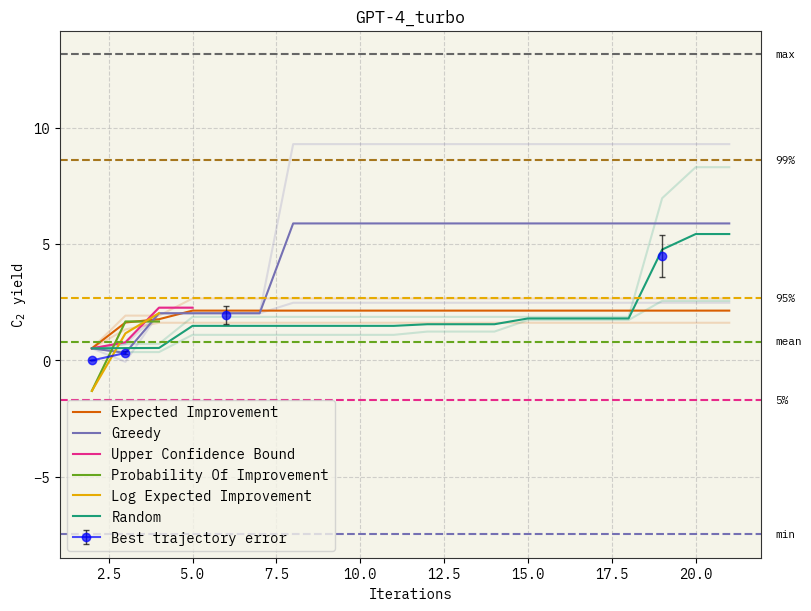

In [52]:
import matplotlib.pyplot as plt

lim = {
    'y_min': raw_data[y_name].min() - 1,
    'y_max': raw_data[y_name].max() + 1
}

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), constrained_layout=True)

plot_BO(
    ax=axs,
    data_file=path,
    title="GPT-4_turbo",
    data=raw_data[y_name],
    axis_name=("Iterations", "C$_2$ yield"),
    lim=lim,          # Now a dictionary
    label=True,
    M=M,
    initial_train=initial_train  # Ensure 'initial_train' is defined
)

plt.show()


### Paper figures

Data indexing error for 'random_mean' in run 0: index 2 is out of bounds for axis 2 with size 2
Data indexing error when computing mean for 'random_mean': index 2 is out of bounds for axis 2 with size 2
Data indexing error when computing mean line for 'random_mean': index 2 is out of bounds for axis 2 with size 2


AttributeError: 'tuple' object has no attribute 'get'

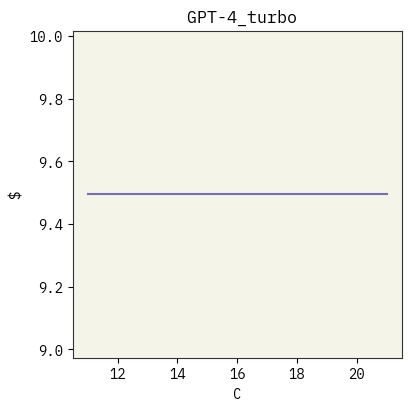

In [150]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(raw_data[y_name].min()-1, raw_data[y_name].max()+1)
# plot_BO(axs[0], "./out/ocm_curie_12744_1_1_16nr.pkl","GPT3", 
#          raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

# plot_BO(axs[0], "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected.pkl","Bias Free: lambda .1_corrected",
#          raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

# plot_BO(axs[1], "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.5_corrected.pkl","Bias Free: lambda .5_corrected",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

# plot_BO(axs[2], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.9_corrected.pkl","Bias Free: lambda .9_corrected",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)


# plot_BO(axs, "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tableprompt_transfer_data_10.pkl","GPT 4 Bias Free Table Format t_train=10: lambda .1",
#          raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)


# plot_BO(axs, './out/ocm_gpt-turbo_1_1_lambda_mult0.1_corrected_tableprompt_1initialpoint_allacq.pkl'," GPT-4turbo",
#          raw_data[y_name], "C$_2$ yield", lim, label=True, M=1)



plot_BO(axs, path," GPT-4_turbo",
         raw_data[y_name], "C$_2$ yield", lim, label=True, M=M)

# plot_BO(axs[1], './out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tableprompt_transfer_data_100.pkl'," GPT4 Table Format: lambda .1",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

# plot_BO(axs[4], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult1.pkl","Bias Free: lambda 1",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

# plot_BO(axs[3], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult1_corrected_1.pkl","Bias Free: lambda 1_corrected",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)


# path = f"./out/{dataset}_{model}_300_{initial_train}_{ask_K}_lambda_mult{lambda_multi}.pkl"

# plot_BO(axs[1], "./out/ocm_GPT-4_12744_0_s.pkl", "GPT4",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)
# d
# plot_BO(axs[2], "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tablepromptgpt4_1.5*normal.pkl", "GPT4 Table Format: lambda .1 - 1.5*",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

# plot_BO(axs[3], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tablepromptgpt4_1.5*normal_meanstart.pkl", "GPT4 Table Format (mean): lambda .1 - 1.5*",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

fig.suptitle("Bayesian Optimization on OCM dataset")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"/Users/shane/repos/BO-LIFT/figs/BO_C2_GPT4", dpi=300, bbox_inches='tight')
plt.show()

In [74]:
path

'./out/ocm_gpt-4_1_1_lambda_mult0.1_corrected_tableprompt_wlog_probs.pkl'

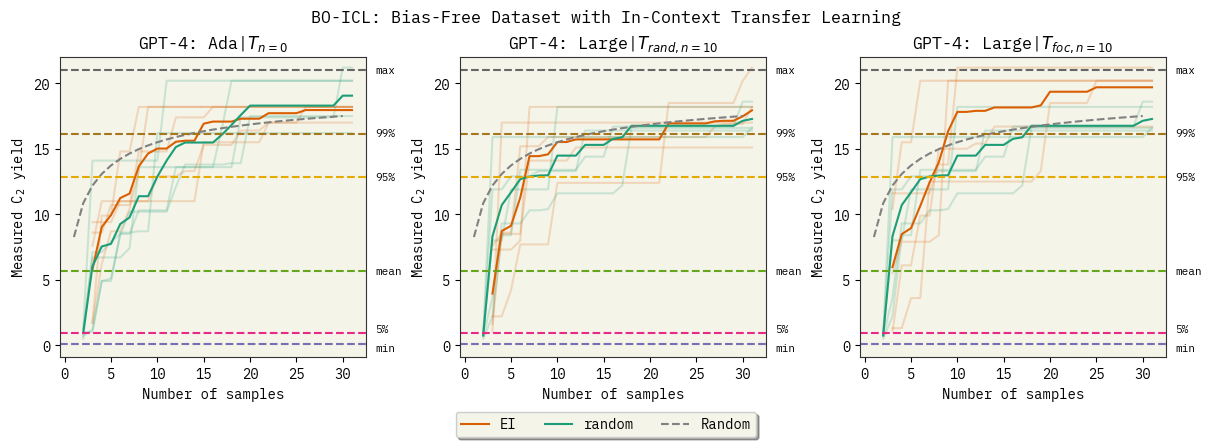

In [106]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
axs = axs.flatten()
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(raw_data[y_name].min()-1, raw_data[y_name].max()+1)

plot_BO(axs[0], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tablepromptgpt44.pkl","GPT-4: Ada|$T_{n=0}$",

         raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

plot_BO(axs[1], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tableprompt_transfer_data_10_large_embedd.pkl", "GPT-4: Large|$T_{rand,n=10}$",
         raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

plot_BO(axs[2], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tableprompt_transfer_data_cosine_10_large_embedd.pkl", "GPT-4: Large|$T_{foc,n=10}$",
         raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

fig.suptitle("BO-ICL: Bias-Free Dataset with In-Context Transfer Learning")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"/Users/shane/repos/BO-LIFT/figs/BO_C2_paper", dpi=300, bbox_inches='tight')
plt.savefig('BO-ICL: Bias-Free Dataset with In-Context Transfer Learning', dpi=500)

plt.show()


In [ ]:
d_curie = cloudpickle.load(open("./out/ocm_curie_12744_1_1_16nr.pkl", "rb"))
d_davinci = cloudpickle.load(open("./out/C2_davinci2_12744_1_16nr.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("./out/ocm_GPT-4_12744_0_s.pkl", "rb"))
d_gpr = cloudpickle.load(open("./out/C2_gpr_12744_1_16nr.pkl", "rb"))

print(d_curie['expected_improvement'][:, -1, 2].astype(float))
best_curie = d_curie['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Curie is top{np.sum(raw_data[y_name] > best_curie)}: {best_curie}")

print(d_davinci['expected_improvement'][:, -1, 2].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 2].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 2].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_curie, color='C4', linestyle='--', label="Curie")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



In [ ]:
raw_data, starts, indexes, x_name, y_name = get_dataset("sol", M=0)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(1.8)

lim=(raw_data[y_name].mean()-1, raw_data[y_name].max()+1)

plot_BO(axs[0], "./out/sol_davinci_100.pkl", "GPT3.5",
         raw_data[y_name], "LogS solubility", lim, label=False)
plot_BO(axs[1], "./out/sol_gpt4_100.pkl", "GPT4",
         raw_data[y_name], "LogS solubility", lim, label=False)
plot_BO(axs[2], "./out/sol_GPR_100.pkl", "GPR",
         raw_data[y_name], "LogS solubility", lim, label=True)

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_sol", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
d_davinci = cloudpickle.load(open("./out/sol_davinci_100.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("./out/sol_gpt4_100.pkl", "rb"))
d_gpr = cloudpickle.load(open("./out/sol_GPR_100.pkl", "rb"))

print(d_davinci['expected_improvement'][:, -1, 2].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 2].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 2].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_sol", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci-0.08])



### C2

In [ ]:
# np.random.seed(88)

# data_path = "./dataset/data/12744_ocm_dataset.csv"
# raw_data = pd.read_csv(data_path, sep=";")
# # raw_data = raw_data.sample(frac=1).reset_index(drop=True)
# # raw_data['completion'] = - raw_data['completion']

# x_name = "prompt"
# y_name = "completion"

In [ ]:
raw_data, starts, indexes, x_name, y_name = get_dataset("ocm", M=5)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_tree.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_tree.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_tree.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_tree_2.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

fig.suptitle("TreePool with davinci")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    './out/C2_davinci_1180_1_tree.pkl',
    './out/C2_davinci_2950_1_tree.pkl',
    './out/C2_davinci_5900_1_tree.pkl',
    './out/C2_davinci_12744_1_tree.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for run in d['upper_confidence_bound'][:, :, 0]:
        print([r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_16hh.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_16hh.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_16hh.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_16hh.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")
         

fig.suptitle("Subpool of 16 with half random samples with davinci")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    './out/C2_davinci_1180_1_16hh.pkl',
    './out/C2_davinci_2950_1_16hh.pkl',
    './out/C2_davinci_5900_1_16hh.pkl',
    './out/C2_davinci_12744_1_16hh.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for run in d['upper_confidence_bound'][:, :, 0]:
        print([r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_fulldataset_new_subpool_16_allrandom_1init.pkl","all_random",
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[1], "./out/C2_davinci_12744_1_16hh.pkl","half_random",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[2], "./out/C2_davinci_fulldataset_subpool_16_no_random_1_init.pkl", "no_random",
# plot_BO(axs[2], "./out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl", "no_random",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[3], "./out/C2_davinci_12744_1_tree_2.pkl", "TreePool",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")
         

fig.suptitle("216 samples with each subpool")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    # './out/C2_davinci_fulldataset_new_subpool_16_allrandom_1init.pkl',
    # './out/C2_davinci_12744_1_16hh.pkl',
    # './out/C2_davinci_fulldataset_subpool_16_no_random_1_init.pkl',
    './out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl',
    # './out/C2_davinci_12744_1_tree.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for k in d.keys():
        for run in d[k][:, :, 0]:
            print(k, [r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
d_davinci = cloudpickle.load(open("paper/out/C2_davinci_100.pkl", "rb"))
print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

d_gpt4 = cloudpickle.load(open("paper/out/C2_GPT4_100.pkl", "rb"))
print(d_gpt4['upper_confidence_bound'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

d_gpr = cloudpickle.load(open("paper/out/C2_GPR_100.pkl", "rb"))
print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



### iupac-sol

In [ ]:
np.random.seed(0)
data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)
raw_data = raw_data.dropna()
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['measured log(solubility:mol/L)'] = -raw_data['measured log(solubility:mol/L)']
x_name = "IUPAC"
y_name = "measured log(solubility:mol/L)"

In [ ]:
raw_data, starts, indexes, x_name, y_name = get_dataset("sol", M=5)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1.8)

lim=(-5.5,2)

plot_BO(axs[0], "paper/out/sol_davinci_100.pkl", "Topk - davinci",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[1], "paper/out/sol_gpt4_100.pkl", "Topk - GPT-4",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[2], "paper/out/sol_GPR_100.pkl", "GPR",
         raw_data[y_name], "LogS solubility", lim, label=True, data_file_random="paper/out/sol - random.pkl")

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_sol", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
d_davinci = cloudpickle.load(open("paper/out/sol_davinci_100.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("paper/out/sol_gpt4_100.pkl", "rb"))
d_gpr = cloudpickle.load(open("paper/out/sol_GPR_100.pkl", "rb"))

print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_sol", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci-0.08])

